# Test sur les MFCC

Ressources :
- https://gist.github.com/stevemclaugh/80f192130852353ad53e6d8b6b275983
- https://towardsdatascience.com/recurrent-neural-nets-for-audio-classification-81cb62327990
- https://stackoverflow.com/questions/69418055/how-to-make-wav-file-from-mfcc-sequence
- https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html#librosa.feature.mfcc

In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers

In [3]:
# Chargement dataframe

df = pd.read_csv('../musicCaps/musiccaps-public.csv',sep=";")
print(df)

             ytid  start_s  end_s  \
0     -0Gj8-vB1q4       30     40   
1     -0SdAVK79lg       30     40   
2     -0vPFx-wRRI       30     40   
3     -0xzrMun0Rs       30     40   
4     -1LrH01Ei1w       30     40   
...           ...      ...    ...   
5516  zw5dkiklbhE       15     25   
5517  zwfo7wnXdjs       30     40   
5518  zx_vcwOsDO4       50     60   
5519  zyXa2tdBTGc       30     40   
5520  zzNdwF40ID8       70     80   

                               audioset_positive_labels  \
0                          /m/0140xf;/m/02cjck;/m/04rlf   
1     /m/0155w;/m/01lyv;/m/0342h;/m/042v_gx;/m/04rlf...   
2                                   /m/025_jnm;/m/04rlf   
3                                    /m/01g90h;/m/04rlf   
4                                   /m/02p0sh1;/m/04rlf   
...                                                 ...   
5516                                /m/01sm1g;/m/0l14md   
5517                      /m/02p0sh1;/m/04rlf;/m/06j64v   
5518  /m/01glhc;/m/02sgy

In [4]:
# Chargement audio

sample_num = 1 #pick a file to display
filename = df.ytid[sample_num]+str('.wav') #get the filename
y, sr = librosa.load('../music_data/'+str(filename))

(array([129.19921875]),
 array([ 0.67337868,  1.13777778,  1.60217687,  2.06657596,  2.5077551 ,
         2.9721542 ,  3.43655329,  3.90095238,  4.36535147,  4.82975057,
         5.29414966,  5.75854875,  6.19972789,  6.66412698,  7.12852608,
         7.59292517,  8.05732426,  8.52172336,  8.98612245,  9.42730159,
         9.86848073, 10.35609977, 10.79727891, 11.28489796, 11.74929705,
        12.21369615, 12.67809524, 13.11927438, 13.58367347, 14.04807256,
        14.51247166, 14.97687075, 15.44126984, 15.90566893, 16.37006803,
        16.83446712, 17.2524263 , 17.74004535, 18.20444444, 18.66884354,
        19.13324263]))

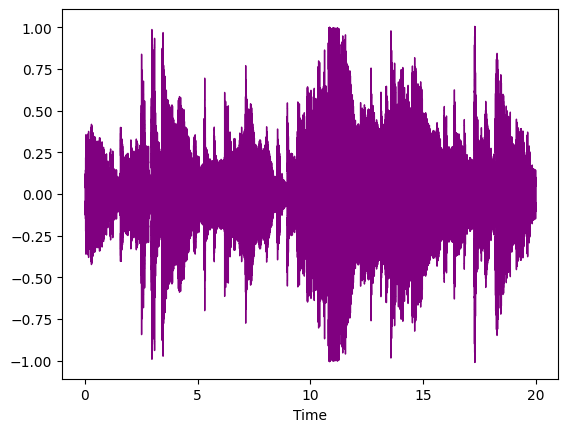

In [5]:
# Frequences

librosa.display.waveshow(y,sr=sr, x_axis='time', color='purple',offset=0.0)
librosa.beat.beat_track(y=y, sr=sr, units="time")

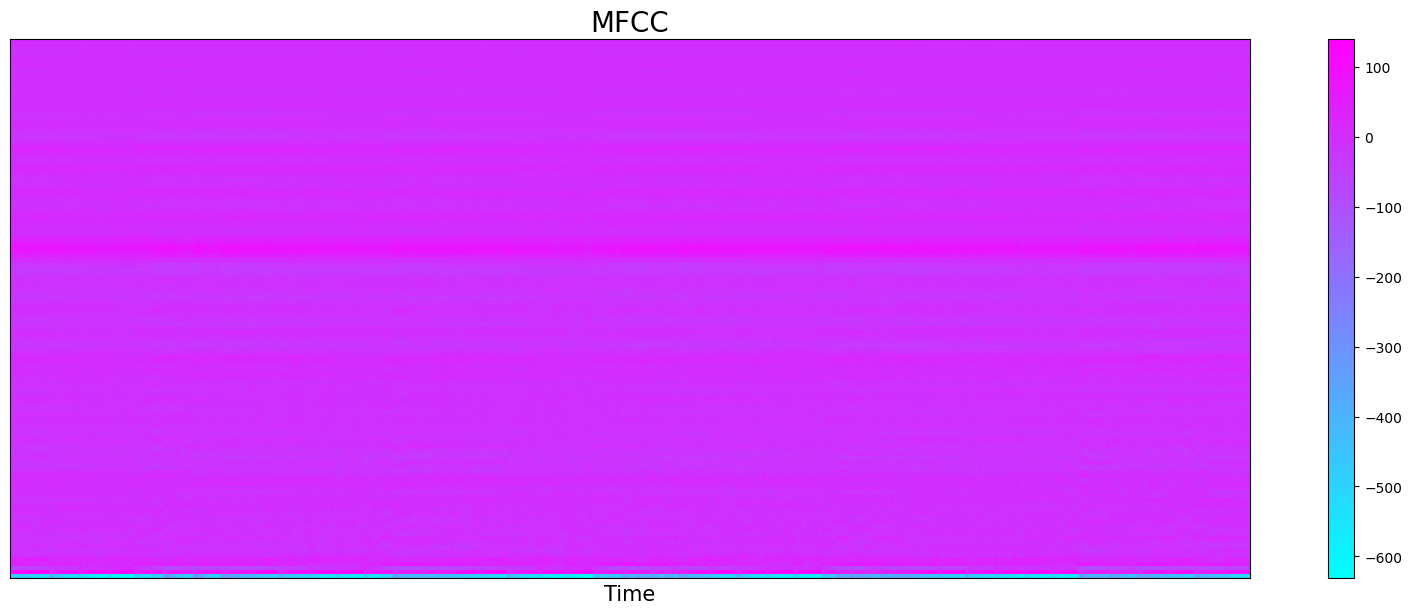

In [6]:
hop_length = 512 #the default spacing between frames
n_fft = 255 #number of samples 

MFCCs = librosa.feature.mfcc(y=y, n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool',hop_length=hop_length)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

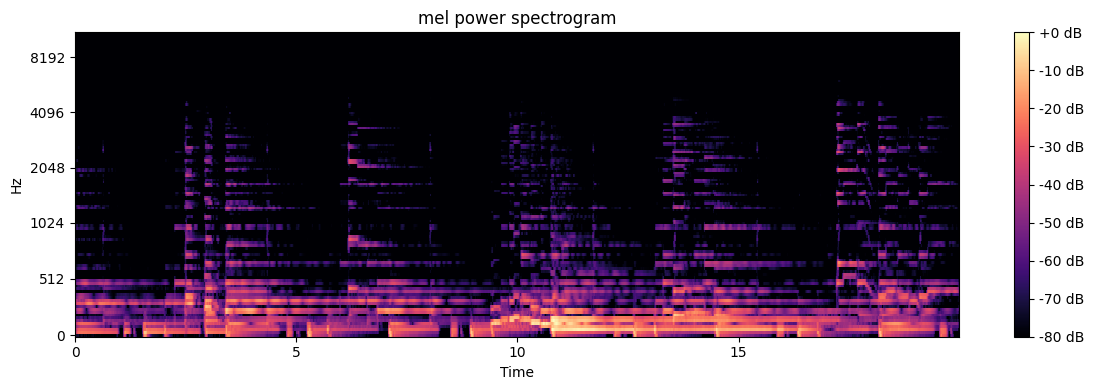

In [7]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.amplitude_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

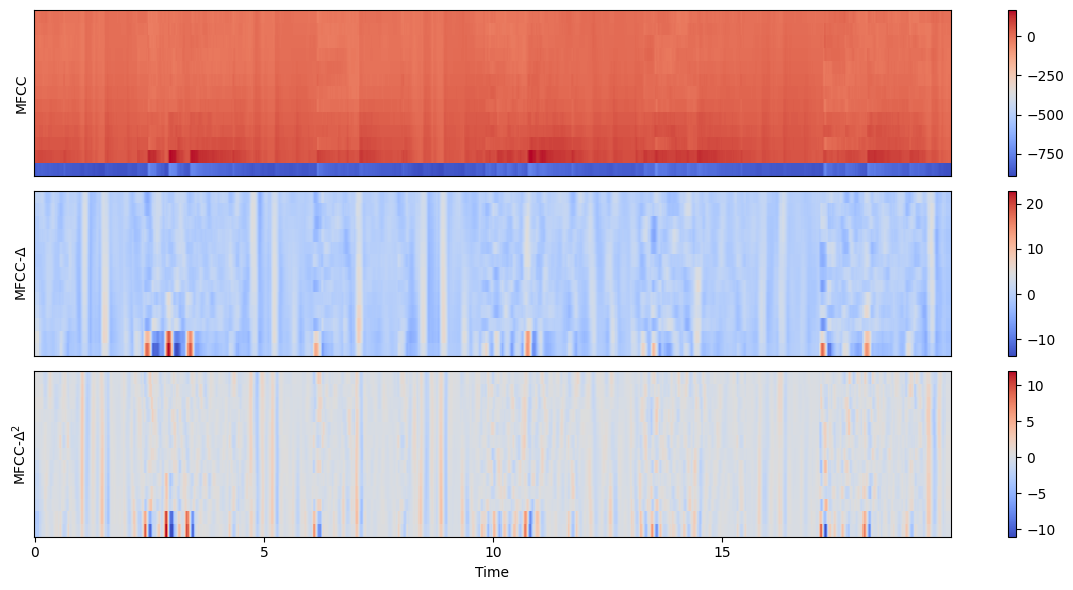

In [8]:
# Next, we'll extract the first 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc = librosa.feature.mfcc(S=log_S, n_fft=2048, n_mfcc=13, hop_length=512)

# Padding first and second deltas
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# Stacking these 3 tables together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

In [9]:
# Export

import soundfile as sf

yMFCC = librosa.feature.mfcc(y=y,sr=sr)
M = librosa.feature.inverse.mfcc_to_audio(yMFCC, sr=sr, n_fft=2048)
sf.write('out.wav', M, 22050, 'PCM_24')

In [13]:
def extractTags(tags):
    tags = tags.replace("[","")
    tags = tags.replace("]","")
    tags = tags.replace("'","")
    return tags.split("; ")

def get_features(df_in):
    features = [] #list to save features
    labels = [] #list to save labels
    for index in range(0, len(df_in)):       
        filename = df_in.iloc[index]['ytid']+str('.wav') 
        tags = extractTags(df_in.iloc[index]['aspect_list'])
        caption = df_in.iloc[index]['caption']
  
        y, sr = librosa.load('../train/'+filename,sr=28000)

        mfcc = np.array(librosa.feature.mfcc(y=y, n_fft=n_fft, hop_length=hop_length, n_mfcc=128))
        beat,occur = librosa.beat.beat_track(y=y, sr=sr, units="time")

        features.append(mfcc)
        features.append(beat)
        features.append(occur)

        labels.append(tags)
        labels.append(labels)

    output=np.concatenate(features,axis=0)
    return(np.array(output), labels)

dfTr = pd.read_csv('../musicCaps/training.csv',sep=";")
X,y=get_features(dfTr)
print(X,y)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)